<a href="https://colab.research.google.com/github/timesorrow/Machine-Learning/blob/main/ML_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [144]:
import dataclasses
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
data = pd.read_csv("/content/drive/MyDrive/data.csv")
data.rename(columns={data.columns[1]: 'Sales'}, inplace=True)

data = data [0:105]


data.index = pd.to_datetime(data['Month'])
data.index = pd.DatetimeIndex(data.index.values,
                               freq=data.index.inferred_freq)
data.drop(columns='Month',inplace=True)
data.head()




,Sales
1964-01-01,2815.0
1964-02-01,2672.0
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0


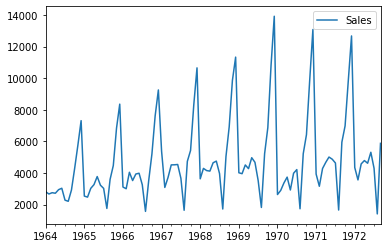

In [145]:
data.isna().sum()
data.plot()



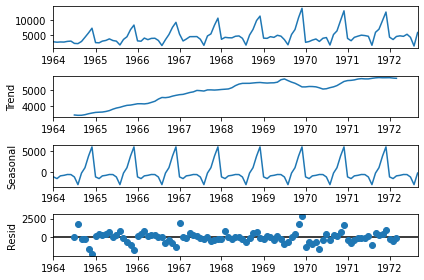

In [146]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_data = seasonal_decompose(data, model="additive")
decompose_data.plot();



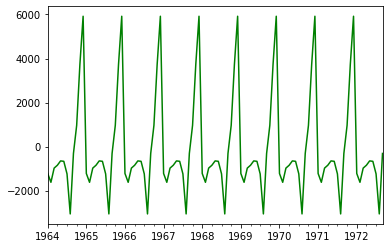

In [147]:
seasonality=decompose_data.seasonal
seasonality.plot(color='green')

In [148]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(data.Sales, autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -1.8335930563276188
2. P-Value :  0.363915771660247
3. Num Of Lags :  11
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 93
5. Critical Values :
	 1% :  -3.502704609582561
	 5% :  -2.8931578098779522
	 10% :  -2.583636712914788


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


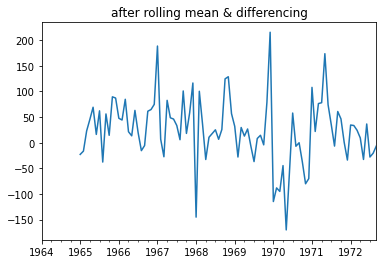

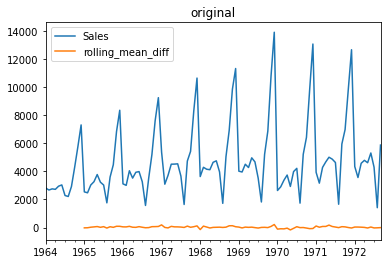

In [149]:
rolling_mean = data.rolling(window = 12).mean()
data['rolling_mean_diff'] = rolling_mean - rolling_mean.shift()
ax1 = plt.subplot()
data['rolling_mean_diff'].plot(title='after rolling mean & differencing');
ax2 = plt.subplot()
data.plot(title='original');

In [150]:
dftest = adfuller(data['rolling_mean_diff'].dropna(), autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
  print("\t",key, ": ", val)

1. ADF :  -7.626619157213174
2. P-Value :  2.0605796968135582e-11
3. Num Of Lags :  0
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 92
5. Critical Values :
	 1% :  -3.503514579651927
	 5% :  -2.893507960466837
	 10% :  -2.583823615311909


In [151]:
from statsmodels.tsa.arima.model import ARIMA
model=ARIMA(data['Sales'],order=(1,1,1))
history=model.fit()
history.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  105
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -952.814
Date:                Wed, 31 Aug 2022   AIC                           1911.627
Time:                        21:28:34   BIC                           1919.560
Sample:                    01-01-1964   HQIC                          1914.841
                         - 09-01-1972                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4545      0.114      3.999      0.000       0.232       0.677
ma.L1         -0.9666      0.056    -17.316      0.000      -1.076      -0.857
sigma2      5.226e+06   6.17e+05      8.473      0.000    4.02e+06    6.43e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.91   Jarque-Bera (JB):                 2.59
Prob(Q):                              0.34   Prob(JB):                         0.27
Heteroskedasticity (H):               3.40   Skew:                             0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

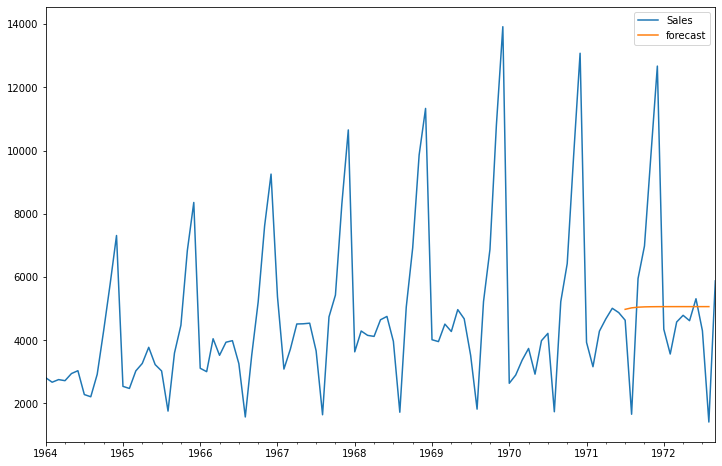

In [152]:
data['forecast']=history.predict(start=90,end=103,dynamic=True)
data[['Sales','forecast']].plot(figsize=(12,8))

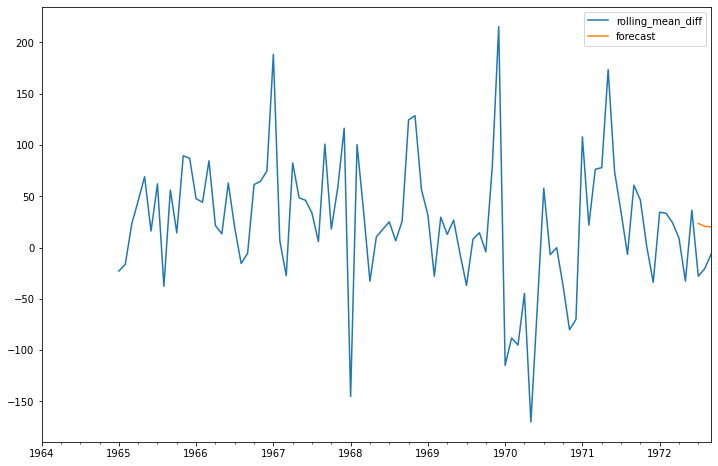

In [153]:
model=ARIMA(data['rolling_mean_diff'].dropna(),order=(1,1,1))
model_fit=model.fit()
data['forecast']=model_fit.predict(start=90,end=103,dynamic=True)
data[['rolling_mean_diff','forecast']].plot(figsize=(12,8))

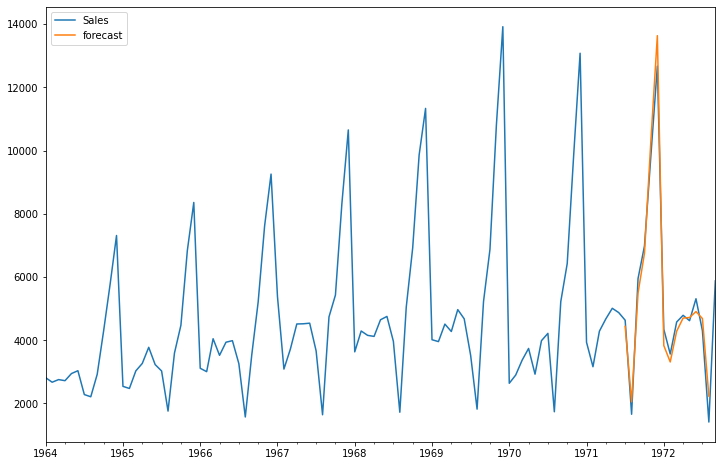

In [154]:
import statsmodels.api as sm

model=sm.tsa.statespace.SARIMAX(data['Sales'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()

data['forecast']=results.predict(start=90,end=103,dynamic=True)
data[['Sales','forecast']].plot(figsize=(12,8))

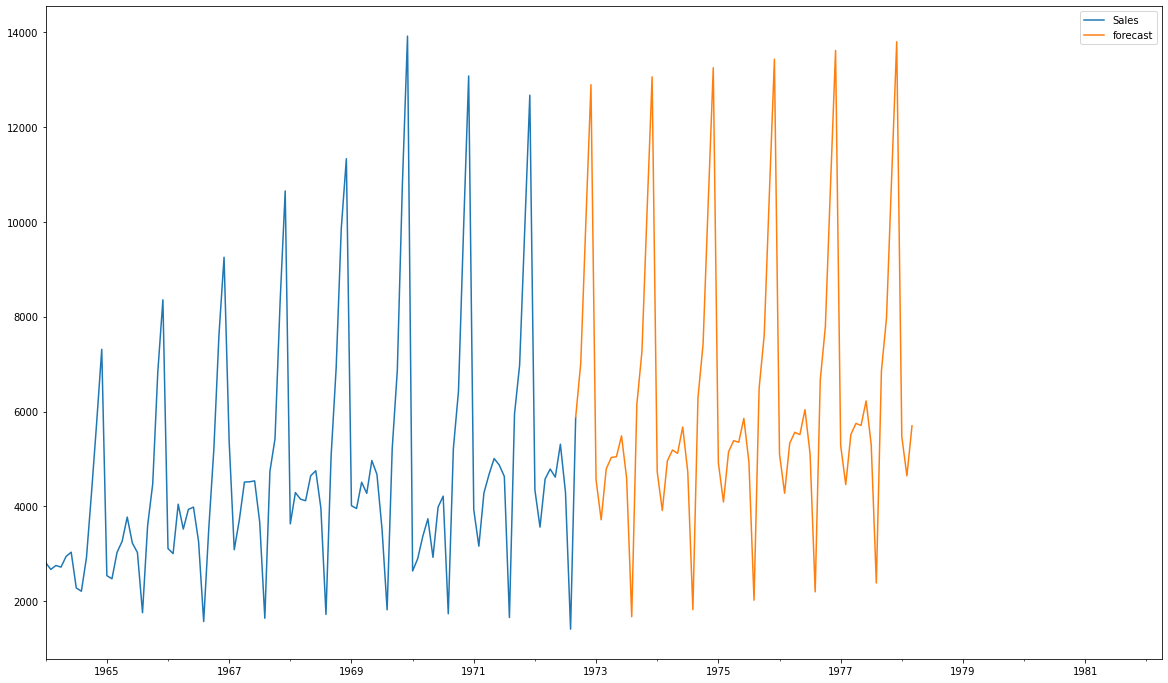

In [159]:
from pandas.tseries.offsets import DateOffset
pred_date=[data.index[-1]+ DateOffset(months=x)for x in range(0,24)]

pred_date=pd.DataFrame(index=pred_date[1:],columns=data.columns)

data=pd.concat([data,pred_date])

data['forecast'] = results.predict(start = 104, end = 170, dynamic= True)  
data[['Sales', 'forecast']].plot(figsize=(20, 12))
